# Info

3 models are tested on bands and vegedation indices data. Model training are customised to the dataset structure, please, explore it and helper functions before to start

In [1]:
!pip3 -q install yellowbrick
!pip3 -q install imblearn
!pip3 -q install scienceplots

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
#libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import os

#clustering
from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from yellowbrick.cluster import KElbowVisualizer
#for PCA option
from sklearn.decomposition import PCA

#test/train split and hyperparameters optimisation
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupShuffleSplit

#ML
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, cohen_kappa_score 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

#stats
import scipy.stats

#utils for visualisation
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

plt.style.use(['science', 'no-latex'])

sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update({
    "font.family": "serif",  
    "font.serif": ["Times"],  
    "font.size":9,
    "axes.labelsize":9,
    "xtick.labelsize" : 9,
    "ytick.labelsize" : 9})    

dict_normal_names={7: "Pine", 
        5:"Aspen",
        1:"Birch",
        6:"Silver fir",
        15:"Burnt forest", 
        13:'Deforestation', 
        14:'Grass',
        12:'Soil', 
        16:'Swamp', 
        11:'Water body',
        17:'Settlements'}

colors =[
    '#117733',
    '#50CE57',
    '#23A28F',
    '#5BD0AE',
    '#88CCEE', 
    '#92462D', 
    '#DE7486',
    '#DDCC77',
    '#AA4499',
    '#0f62fe',
    '#be95ff'
]

#model saving
from joblib import dump, load

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Helpers

In [4]:
#for getting model predictions
def get_predictions(data_scaled, 
                    model,
                    param_grid, 
                    target_column,
                    split_rate: float=0.25,
                    smote_balance: bool=True,
                    cv: int=5, 
                    n_iter_search: int=3):

    labels = data_scaled[target_column] #get label data
    indices=np.arange(data_scaled.shape[0]) #get indices numpy
    
    while True:
        train_inds, test_inds = train_test_split(indices,
                                                 test_size=split_rate, 
                                                 stratify=labels)
        train = data_scaled.iloc[train_inds]
        test = data_scaled.iloc[test_inds]
        if len(train[target_column].unique(
        )) == len(test[target_column].unique(
        )) == len(data_scaled[target_column].unique()): #because we need target feature to be represented in train and test
            break
            

    #class balansing with smote
    if smote_balance is True:
        smote = SMOTE(random_state = 42)
        X, y = smote.fit_resample(train.loc[:, train.columns!=target_column],
                                  train[target_column]) #drops 3 columns: key, class, and forest
        df_smote = pd.DataFrame(X, columns = train.loc[:, train.columns!=target_column].columns.tolist()) #drops 3 columns: key, class, and forest
        
        #we set train/test from SMOTE results
        X_train = df_smote
        y_train = y
        X_test = test.loc[:, train.columns!=target_column]  
        y_test = test[target_column]
        #we set train/test as it is
    else:
        X_train = train.loc[:, train.columns!=target_column]
        y_train = train[target_column]
        X_test = test.loc[:, train.columns!=target_column] 
        y_test = test[target_column]
    print(X_train.columns)
    #parameters optimisation
    
    gs = RandomizedSearchCV(model, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            scoring= 'f1_weighted', verbose=2)
    gs.fit(X_train, y_train)  
    y_pred = gs.best_estimator_.predict(X_test)
    model_fit = gs.best_estimator_
    
    results = {'model': model_fit,
               'X_train data': X_train,
               'y train data':  y_train,
               'X test data': X_test,
               'y test data': y_test,
               'y predicted': y_pred
        
    }

    return results

In [5]:
def metrics_description(y_true, y_pred, 
                        metrics_by_class: bool=True, 
                        confusion_matrix_multiclass_on: bool=True,
                        binary_matrix_on: bool=False):

    
    print('Accuracy score: %.2f%%' %(accuracy_score(y_true, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_true, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_true, y_pred, average= 'weighted')*100))
    print('F1-Score: %.2f%%'%(f1_score(y_true, y_pred, average = 'weighted')*100))
    print('Kappa score: %.2f%%'%(cohen_kappa_score(y_true, y_pred)*100))
    
    
    #dataframe with metrics by class
    if metrics_by_class is True:
        metrics_by_class = pd.DataFrame(
                {
                    'names': list(map(dict_normal_names.get, list(np.unique(y_true)))),
                    'f1_scores': f1_score(y_true, y_pred,
                               average=None).round(2).tolist(),
                    'precision_list': precision_score(y_true, y_pred, 
                                       average=None).round(2).tolist(),
                    'recall':recall_score(y_true, y_pred,
                                       average=None).round(2).tolist()
                }
            )
        display(metrics_by_class)

    #confusion matrix multiclass
    if confusion_matrix_multiclass_on is True:
        data = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(data, columns=list(map(dict_normal_names.get, list(np.unique(y_true)))), 
                             index = list(map(dict_normal_names.get, list(np.unique(y_true)))))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'

        #confusion matrix plot
        f, ax = plt.subplots(figsize=(6, 10))
        cmap = sns.cubehelix_palette(light=1, as_cmap=True)

        sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
                    annot_kws={'size': 10})
        plt.title('Actuals vs Predicted')
        plt.show()
        
    #confusion matrix binary    
    if binary_matrix_on is True:
        cm = confusion_matrix(y_true, y_pred)
        print('Confusion matrix\n\n', cm)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [6]:
#getting dataset with metrics by class for each random prediction
def get_classes_metrics(models_vector): #vector with model variations, y predicted and y true from the dataset
    class_metrics_dataframe = pd.DataFrame()
    count = 0 #counter of iteration

    for i in models_vector:

        count += 1 #counting
        pred = i['y predicted'] #predicted values 
        true = i['y test data'] #corresponding labels from random test set
        names_list = list(np.unique(true))

        temp = pd.DataFrame(
            {
                'iteration':[count]*len(names_list), 
                'names': list(map(dict_normal_names.get, names_list)),
                'f1_scores': f1_score(true, pred,
                           average=None).round(2).tolist(),
                'precision_list': precision_score(true, 
                                   pred, 
                                   average=None).round(2).tolist(),
                'recall':recall_score(true, 
                                   pred, 
                                   average=None).round(2).tolist()
            }
        ) #dataset for each model 

        class_metrics_dataframe = pd.concat([class_metrics_dataframe, temp], ignore_index=True)
    return class_metrics_dataframe 

In [7]:
#getting dataset with average metrics for each random prediction
def get_metrics_average(models_vector): #vector with model variations, y predicted and y true from the dataset
    average_metrics_dataframe = pd.DataFrame()
    count = 0 #counter of iteration

    for i in models_vector:

        count += 1 #counting
        pred = i['y predicted'] #predicted values 
        true = i['y test data'] #corresponding labels from random test set

        temp = pd.DataFrame(
            {
                'iteration':[count],#*len(names_list), 
                #'names': list(map(dict_normal_names.get, names_list)),
                'f1_scores': f1_score(true, pred,
                           average='macro').round(2).tolist(),
                'precision_list': precision_score(true, 
                                   pred, 
                                   average='weighted').round(2).tolist(),
                'recall':recall_score(true, 
                                   pred, 
                                   average='weighted').round(2).tolist()
            }
        ) #dataset for each model 

        average_metrics_dataframe = pd.concat([average_metrics_dataframe, temp], 
                                              ignore_index=True)
    return average_metrics_dataframe 

In [8]:
def get_best_model(datavector_models):
    number = get_metrics_average(datavector_svc_wf).sort_values(by='f1_scores', 
                                                                ascending=False).head(1).reset_index()['index'].values[0]
    best_model = datavector_models[number]['model']
    return best_model

In [52]:
def get_worst_model(datavector_models):
    number = get_metrics_average(datavector_svc_wf).sort_values(by='f1_scores', 
                                                                ascending=False).tail(1).reset_index()['index'].values[0]
    best_model = datavector_models[number]['model']
    return best_model

# Data preparation

In [9]:
def get_scaled_data(path):
    df = pd.read_csv(path)
    df = df.iloc[:, 1:] #fix the dataset and remove later
    x = df.iloc[:, :-2].values #returns values as a numpy array
    min_max_scaler = preprocessing.MinMaxScaler() #minmax scaling
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled, columns = list(df.iloc[:, :-2].columns))
    df_scaled = pd.concat([df_scaled, df.iloc[:, -2:]], axis=1)
    return df_scaled, min_max_scaler
folder = '../shape_data'
df_scaled, min_max_scaler = get_scaled_data(os.path.join(folder, 'dataset_scale_1.csv'))

## Model training

### Random Forest

In [10]:
#for random forest
n_estimators = np.arange(100,600,10)
max_depth = np.arange(10,110,11)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# vector of 5 model iterations to evaluate average performance
datavector_rf_wf = []
for i in range(5):
    print(f'start {i}')
    rf_model = get_predictions(data_scaled = df_scaled,
                model = RandomForestClassifier(bootstrap=True, n_jobs=-1),
                param_grid = random_grid,
                target_column = 'class', # [MG]: был id, а это что было? 
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_rf_wf.append(rf_model)
    break 

start 0
Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'NDVI', 'EVI', 'MSAVI', 'NDRE', 'FCI', 'aspect', 'slope',
       'wetnessindex', 'sink', 'ASM1', 'ASM2', 'contrast1', 'contrast2',
       'correlation1', 'correlation2', 'dissimilarity1', 'dissimilarity2',
       'energy1', 'energy2', 'homogeneity1', 'homogeneity2', 'key'],
      dtype='object')
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END max_depth=87, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.2s
[CV] END max_depth=87, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.2s
[CV] END max_depth=87, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.1s
[CV] END max_depth=87, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.1s
[CV] END max_depth=87, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.1s
[CV] END max_depth=87, min_

In [ ]:
metrics_description(datavector_rf_wf[3]['y test data'], datavector_rf_wf[3]['y predicted'])

In [45]:
rf_class_metrics = get_classes_metrics(datavector_rf_wf)

In [ ]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = rf_class_metrics['names'],
            y = rf_class_metrics['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('RF multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('RF_multiclass_F1_score.png', dpi = 300)
plt.show()

In [16]:
get_metrics_average(datavector_rf_wf)
rf_best_model = get_best_model(datavector_rf_wf)

In [39]:
rf_worst_model = get_worst_model(datavector_rf_wf)

### SVC

In [ ]:
# svc random grid

svc_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']
             }

# vector of 5 model iterations to evaluate average performance

datavector_svc_wf = []
for i in range(5):
    svc_model = get_predictions(data_scaled = df_scaled,
                model = SVC(),
                param_grid = svc_grid,
                target_column = 'class', 
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_svc_wf.append(svc_model)

In [18]:
datavector_svc_wf[0].keys()

dict_keys(['model', 'X_train data', 'y train data', 'X test data', 'y test data', 'y predicted'])

Accuracy score: 96.66%
Precision score: 96.68%
Recall score: 96.66%
F1-Score: 93.89%
Kappa score: 95.44%


,names,f1_scores,precision_list,recall
0,trees,0.92,0.91,0.93
1,flooded vegetation,0.88,0.86,0.89
2,open water,1.00,1.00,1.00
3,settlements,0.96,0.96,0.96
4,bare soil,0.96,0.95,0.97
5,agriculture,1.00,1.00,1.00
6,shrubs,0.86,0.93,0.79


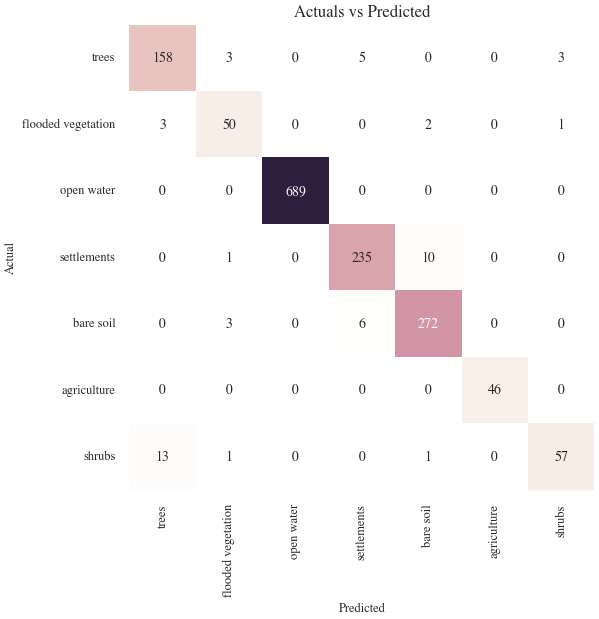

In [19]:
metrics_description(datavector_svc_wf[3]['y test data'], datavector_svc_wf[3]['y predicted'])

In [20]:
svc_class_metrics = get_classes_metrics(datavector_svc_wf)

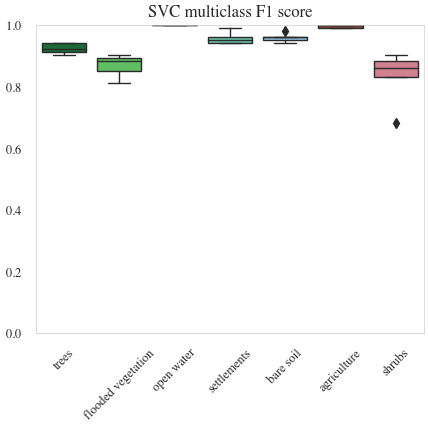

In [21]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = svc_class_metrics['names'],
            y = svc_class_metrics['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('SVC multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('SVC_multiclass_F1_score.png', dpi = 300)
plt.show()

In [33]:
display(get_metrics_average(datavector_svc_wf))
svc_best_model = get_best_model(datavector_svc_wf)

,iteration,f1_scores,precision_list,recall
0,1,0.96,0.98,0.98
1,2,0.95,0.97,0.97
2,3,0.90,0.95,0.95
3,4,0.94,0.97,0.97
4,5,0.92,0.96,0.96


In [40]:
svc_worst_model = get_worst_model(datavector_svc_wf)

## kNN

In [27]:
#knn random grid
metric = ['euclidean','manhattan','chebyshev','minkowski']
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)] 
weights = ['uniform','distance']
random_grid_knn = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric
}

# vector of 5 model iterations to evaluate average performance on non-filtered data
datavector_knn_wf = []

for i in range(5):
    knn_model_wf = get_predictions(data_scaled=df_scaled,
                model = KNeighborsClassifier(),
                param_grid = random_grid_knn,
                target_column = 'id', 
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_knn_wf.append(knn_model_wf)

Accuracy score: 94.87%
Precision score: 95.20%
Recall score: 94.87%
F1-Score: 88.82%
Kappa score: 92.99%


,names,f1_scores,precision_list,recall
0,trees,0.90,0.93,0.88
1,flooded vegetation,0.66,0.63,0.68
2,open water,1.00,1.00,1.00
3,settlements,0.94,0.97,0.92
4,bare soil,0.96,0.95,0.96
5,agriculture,0.99,1.00,0.98
6,shrubs,0.77,0.70,0.85


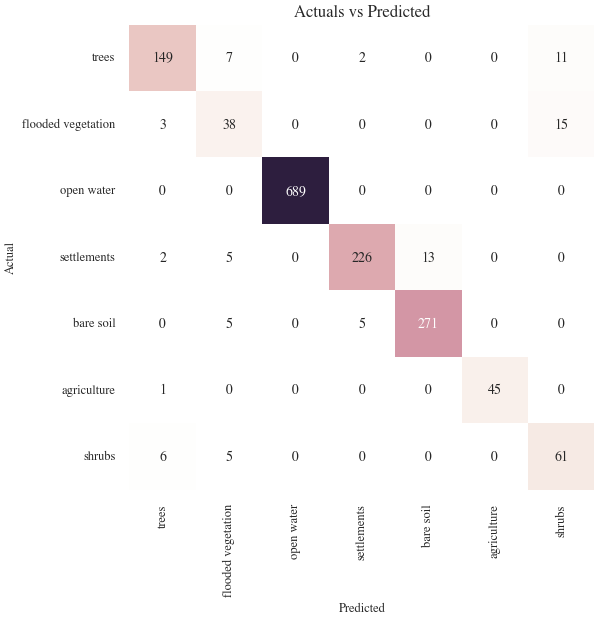

In [28]:
metrics_description(datavector_knn_wf[3]['y test data'], datavector_knn_wf[3]['y predicted'])

In [29]:
knn_class_metrics = get_classes_metrics(datavector_knn_wf)

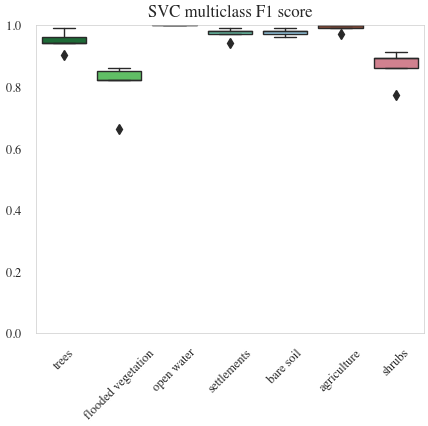

In [30]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = knn_class_metrics['names'],
            y = knn_class_metrics['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('SVC multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('SVC_multiclass_F1_score.png', dpi = 300)
plt.show()

In [32]:
display(get_metrics_average(datavector_knn_wf))
knn_best_model = get_best_model(datavector_knn_wf)

,iteration,f1_scores,precision_list,recall
0,1,0.96,0.99,0.99
1,2,0.95,0.98,0.98
2,3,0.95,0.97,0.97
3,4,0.89,0.95,0.95
4,5,0.94,0.98,0.97


In [41]:
knn_worst_model = get_worst_model(datavector_knn_wf)

# Saving models

In [47]:
dump(svc_best_model, 'svc_best_model.joblib')
dump(rf_best_model, 'rf_best_model.joblib')
dump(knn_best_model, 'knn_best_model.joblib')

['knn_best_model.joblib']

In [48]:
dump(svc_worst_model, 'svc_worst_model.joblib')
dump(rf_worst_model, 'rf_worst_model.joblib')
dump(knn_worst_model, 'knn_worst_model.joblib')

['knn_worst_model.joblib']

## Forest mask classification 

In [132]:
def NDVI(red: pd.Series, nir: pd.Series):
    ndvi = (nir - red) / ((nir + red).apply(lambda x: 0.000001 if x == 0 else x))
    return ndvi

def EVI(red: pd.Series, nir: pd.Series):
    evi2 = (
        2.5
        * (nir - red)
        / ((nir + 2.4 * red + 1).apply(lambda x: 0.000001 if x == 0 else x))
    )
    return evi2

def NDRE(red_far: pd.Series, nir: pd.Series):
    ndre = (nir - red_far) / (
        (nir + red_far).apply(lambda x: 0.000001 if x == 0 else x)
    )
    return ndre

def MSAVI(red: pd.Series, nir: pd.Series):
    msavi = (2 * nir + 1 - ((2 * nir + 1) ** 2 - 8 * (nir - red)) ** (1 / 2)) / 2
    return msavi


def FCI(red: pd.Series, nir: pd.Series):
    fci = np.sqrt(red * nir)
    return fci

def normalize_pixel(X: np.ndarray) -> np.ndarray:
        X = X / 10000
        X = np.clip(X, 0, 0.3)
        return X
    
        
def get_SVI(df: pd.DataFrame) -> pd.DataFrame:
    nir = df.loc[:, "B08"]
    red = df.loc[:, "B04"]
    red_far = df.loc[:, "B05"]
    df.loc[:, "NDVI"] = NDVI(red=red, nir=nir)
    df.loc[:, "EVI"] = EVI(red=red, nir=nir)
    df.loc[:, "MSAVI"] = MSAVI(red=red, nir=nir)
    df.loc[:, "NDRE"] = NDRE(red_far=red_far, nir=nir)
    df.loc[:, "FCI"] = FCI(red=red, nir=nir)
    return df


def get_tiles(ds, width=256, height=256):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

def get_dataset(x: np.ndarray)->pd.DataFrame:
    
    
    col_names = ["B01","B02","B03","B04",
            "B05","B06","B07","B08",
            "B8A","B09","B10","B11","B12"]
    texture_columns = [
            "ASM1",
            "ASM2",
            "contrast1",
            "contrast2",
            "correlation1",
            "correlation2",
            "dissimilarity1",
            "dissimilarity2",
            "energy1",
            "energy2",
            "homogeneity1",
            "homogeneity2",
        ]
    bands = x[:13, ...]
    bands = to_2d_array(x[:13, ...])    
    df = pd.DataFrame(bands.T, columns=col_names)
    df[col_names] = normalize_pixel(df.values)
    df = df.drop(columns='B10')
    df = get_SVI(df)
    terrain = to_2d_array(x[16:20, ...])
    df_terrain = pd.DataFrame(terrain.T, columns=["aspect", "slope", 
                                                      "wetnessindex", "sink"])
    mask = df_terrain["wetnessindex"] < 0
    df_terrain.loc[mask, "wetnessindex"] = 0    


    texture = to_2d_array(x[20:32, ...])
    df_texture = pd.DataFrame(texture.T, columns=texture_columns)
    return pd.concat([df,df_terrain, df_texture], axis=1)

def to_2d_array(x: np.ndarray)->np.ndarray:
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def save_tif(raster_input:str, raster_output:str, values:np.array):
    in_data, out_data = None, None
    in_data = gdal.Open(raster_input)
    if in_data is None:
        print ('Unable to open %s' % raster_input)
    band1 = in_data.GetRasterBand(1)
    rows = in_data.RasterYSize
    cols = in_data.RasterXSize
    driver = in_data.GetDriver()
    out_data = driver.Create(raster_output, cols, rows, 1, GDT_Int16)
    dem_data = np.array(values)
    out_band = out_data.GetRasterBand(1)
    out_band.WriteArray(dem_data)
    out_band.FlushCache()
    out_band.SetNoDataValue(-1)

    out_data.SetGeoTransform(in_data.GetGeoTransform())
    out_data.SetProjection(in_data.GetProjection())
    del out_data
    return 'Done'

def save_tif_rasterio(raster_input:str, raster_output:str, values:np.array, nodata: int = 0):
    """
    Save numpy array to geotiff
    """
    with rio.open(raster_input, 'r+') as src: 
        kwargs = src.meta
        kwargs.update(
            dtype=rio.int32,
            count=1,
            compress='lzw',
            nodata=nodata)
    with rio.open(raster_output, 'w', **kwargs) as dst:
        dst.write_band(1, values.astype(rio.int32))
        print(f'Saved geotiff: {raster_output}')
        
        
#for getting model predictions
def get_predictions(data_scaled, 
                    model,
                    param_grid, 
                    target_column,
                    split_rate: float=0.25,
                    smote_balance: bool=True,
                    cv: int=5, 
                    to_drop_columns: list = ['key'],
                    n_iter_search: int=3):
    data_scaled = data_scaled.drop(columns = to_drop_columns)
    labels = data_scaled[target_column] #get label data
    indices=np.arange(data_scaled.shape[0]) #get indices numpy
    
    while True:
        train_inds, test_inds = train_test_split(indices,
                                                 test_size=split_rate, 
                                                 stratify=labels)
        train = data_scaled.iloc[train_inds]
        test = data_scaled.iloc[test_inds]
        if len(train[target_column].unique(
        )) == len(test[target_column].unique(
        )) == len(data_scaled[target_column].unique()): #because we need target feature to be represented in train and test
            break
            

    #class balansing with smote
    if smote_balance is True:
        smote = SMOTE(random_state = 42)
        X, y = smote.fit_resample(train.loc[:, train.columns!=target_column],
                                  train[target_column]) #drops 3 columns: key, class, and forest
        df_smote = pd.DataFrame(X, columns = train.loc[:, train.columns!=target_column].columns.tolist()) #drops 3 columns: key, class, and forest
        df_smote = df_smote
        #we set train/test from SMOTE results
        X_train = df_smote
        y_train = y
        X_test = test.loc[:, test.columns!=target_column]  
        y_test = test[target_column]
        #we set train/test as it is
    else:
        X_train = train.loc[:, train.columns!=target_column]
        y_train = train[target_column]
        X_test = test.loc[:, test.columns!=target_column] 
        y_test = test[target_column]


    print(X_train.columns)
    #parameters optimisation
    
    gs = RandomizedSearchCV(model, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            scoring= 'f1_weighted')
    gs.fit(X_train, y_train)  
    y_pred = gs.best_estimator_.predict(X_test)
    model_fit = gs.best_estimator_
    
    results = {'model': model_fit,
               'X_train data': X_train,
               'y train data':  y_train,
               'X test data': X_test,
               'y test data': y_test,
               'y predicted': y_pred
        
    }

    return results

In [125]:
def get_scaled_data(path):
    df = pd.read_csv(path)
    df = df.iloc[:, 1:] #fix the dataset and remove later
    x = df.iloc[:, :-2].values #returns values as a numpy array
    min_max_scaler = preprocessing.MinMaxScaler() #minmax scaling
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled, columns = list(df.iloc[:, :-2].columns))
    df_scaled = pd.concat([df_scaled, df.iloc[:, -2:]], axis=1)
    return df_scaled, min_max_scaler
folder = '../shape_data'
df_scaled, min_max_scaler = get_scaled_data(os.path.join(folder, 'dataset_scale_1.csv'))

In [136]:
df = df_scaled.copy()

df[['forest']] = -999
# 1. Code forest
mask_forest = df['class'] < 10
df.loc[mask_forest, 'forest'] = 1
df.loc[~mask_forest, 'forest'] = 0

## Random Forest - Forest

In [137]:
#for random forest

# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # [MG]: кажется можно короче чем np.arange
n_estimators = np.arange(200,500,10)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth = np.arange(10,110,11)
# max_depth.append(None) # [MG]: а это зачем? 
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_model = get_predictions(data_scaled = df,
            model = RandomForestClassifier(n_jobs=-1, 
                                           bootstrap=True, 
                                           verbose=0),
            param_grid = random_grid,
            to_drop_columns=['key', 'class'],
            target_column = 'forest', # [MG]: был id, а это что было? 
            smote_balance=False,
            cv=5, 
            n_iter_search=15) # [MG: За что отвечает этот параметр?]
# datavector_rf_wf.append(rf_model)

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'NDVI', 'EVI', 'MSAVI', 'NDRE', 'FCI', 'aspect', 'slope',
       'wetnessindex', 'sink', 'ASM1', 'ASM2', 'contrast1', 'contrast2',
       'correlation1', 'correlation2', 'dissimilarity1', 'dissimilarity2',
       'energy1', 'energy2', 'homogeneity1', 'homogeneity2'],
      dtype='object')


In [135]:
# metrics_description(rf_model['y test data'], rf_model['y predicted'])

### SVC - Forest

In [141]:
# svc random grid

svc_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']
             }

# datavector_svc_wf = []
svc_model = get_predictions(data_scaled = df,
             model = SVC(verbose=0),
            param_grid = svc_grid,
            to_drop_columns=['key', 'class'],
            target_column = 'forest', # [MG]: был id, а это что было? 
            smote_balance=False,
            cv=5, 
            n_iter_search=15) # [MG: За что отвечает этот параметр?]
# datavector_svc_wf.append(svc_model)

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'NDVI', 'EVI', 'MSAVI', 'NDRE', 'FCI', 'aspect', 'slope',
       'wetnessindex', 'sink', 'ASM1', 'ASM2', 'contrast1', 'contrast2',
       'correlation1', 'correlation2', 'dissimilarity1', 'dissimilarity2',
       'energy1', 'energy2', 'homogeneity1', 'homogeneity2'],
      dtype='object')


## kNN - Forest

In [142]:
#knn random grid
metric = ['euclidean','manhattan','chebyshev','minkowski']
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)] 
weights = ['uniform','distance']
random_grid_knn = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric
}



knn_model_wf = get_predictions(data_scaled=df,
                model = KNeighborsClassifier(),
                param_grid = random_grid_knn,
                to_drop_columns=['key', 'class'],
                target_column = 'forest', # [MG]: был id, а это что было? 
                smote_balance=False,
                cv=5, 
                n_iter_search=15) # [MG: За что отвечает этот параметр?]

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'NDVI', 'EVI', 'MSAVI', 'NDRE', 'FCI', 'aspect', 'slope',
       'wetnessindex', 'sink', 'ASM1', 'ASM2', 'contrast1', 'contrast2',
       'correlation1', 'correlation2', 'dissimilarity1', 'dissimilarity2',
       'energy1', 'energy2', 'homogeneity1', 'homogeneity2'],
      dtype='object')


## GradientBoosting - Forest

In [147]:
gb_grid = {
#     "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8, 12],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10, 50, 100, 200]
    }

gb_model = get_predictions(data_scaled=df,
                model = GradientBoostingClassifier(),
                param_grid = gb_grid,
                to_drop_columns=['key', 'class'],
                target_column = 'forest', # [MG]: был id, а это что было? 
                smote_balance=False,
                cv=5, 
                n_iter_search=15) # [MG: За что отвечает этот параметр?]

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'NDVI', 'EVI', 'MSAVI', 'NDRE', 'FCI', 'aspect', 'slope',
       'wetnessindex', 'sink', 'ASM1', 'ASM2', 'contrast1', 'contrast2',
       'correlation1', 'correlation2', 'dissimilarity1', 'dissimilarity2',
       'energy1', 'energy2', 'homogeneity1', 'homogeneity2'],
      dtype='object')


In [148]:
models = {"RandomForest":rf_model['model'],
         "SVC": svc_model['model'],
         "kNN": knn_model_wf['model'],
         "GradientBoosting": gb_model['model']}

In [149]:
import os
import pandas as pd
import numpy as np
import rasterio as rio
from itertools import product
from rasterio import windows
import matplotlib.pyplot as plt


fname = '../rasters/bands_and_terrain_texture.tiff'
def get_forest_mask(raster_input:str,
                    raster_output:str,
                    model, 
                    min_max_scaler: preprocessing.MinMaxScaler):
    with rio.open(raster_input, 'r+') as src:
        meta = src.meta.copy()
        tile_width, tile_height = 512, 512
        output_mask = np.zeros(shape = (meta['height'], meta['width']))
        # Здесь можно добавить tqdm для отслеживания процесса
        for window, transform in get_tiles(src, 
                                           width=tile_width,
                                           height=tile_height):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height

            x = src.read(window=window)
            df_original = get_dataset(x)
            forecast=pd.DataFrame(data=np.ones(shape=(len(df_original), 1))*-1,
                                  columns=['forest'])
            mask_nan = df_original.iloc[:, :5].sum(axis=1)==0
            land_df = df_original.loc[~mask_nan]
            land_df.iloc[:, :] = min_max_scaler.transform(land_df.iloc[:, :])
            forest_preds = model.predict(land_df.values)
            forecast.loc[~mask_nan, 'forest'] = forest_preds
            forest_tile = forecast.values.reshape(meta['height'], meta['width'])
            ranges = window.toranges()
            output_mask[ranges[0][0]:ranges[0][1],ranges[1][0]:ranges[1][1]] = forest_tile
            print(window)
    status = save_tif_rasterio(raster_input=raster_input, 
                               raster_output=raster_output,
                               values=output_mask,
                                  nodata=-1)
    print(raster_output)

In [153]:
df.groupby('forest').count()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,correlation1,correlation2,dissimilarity1,dissimilarity2,energy1,energy2,homogeneity1,homogeneity2,key,class
forest,,,,,,,,,,,,,,,,,,,,,
0,7250,7250,7250,7250,7250,7250,7250,7250,7250,7250,...,7250,7250,7250,7250,7250,7250,7250,7250,7250,7250
1,1759,1759,1759,1759,1759,1759,1759,1759,1759,1759,...,1759,1759,1759,1759,1759,1759,1759,1759,1759,1759


# 🚨 Добавить балансировку классов, не лесных пикселей очень мало -> цепляет много не леса


## Взять SCALE == 3 !!!!

In [150]:
fname = '../rasters/bands_and_terrain_texture.tiff'
for name, model in models.items():
    output = f'../rasters/predictions_{name}.tif'
    get_forest_mask(raster_input=fname,
                    raster_output=output,
                    model=model,
                    min_max_scaler=min_max_scaler)

Window(col_off=0, row_off=0, width=512, height=512)
Window(col_off=0, row_off=512, width=512, height=512)
Window(col_off=0, row_off=1024, width=512, height=512)
Window(col_off=0, row_off=1536, width=512, height=512)
Window(col_off=0, row_off=2048, width=512, height=512)
Window(col_off=0, row_off=2560, width=512, height=512)
Window(col_off=0, row_off=3072, width=512, height=389)
Window(col_off=512, row_off=0, width=512, height=512)
Window(col_off=512, row_off=512, width=512, height=512)
Window(col_off=512, row_off=1024, width=512, height=512)
Window(col_off=512, row_off=1536, width=512, height=512)
Window(col_off=512, row_off=2048, width=512, height=512)
Window(col_off=512, row_off=2560, width=512, height=512)
Window(col_off=512, row_off=3072, width=512, height=389)
Window(col_off=1024, row_off=0, width=512, height=512)
Window(col_off=1024, row_off=512, width=512, height=512)
Window(col_off=1024, row_off=1024, width=512, height=512)
Window(col_off=1024, row_off=1536, width=512, height=5

Window(col_off=3072, row_off=1024, width=87, height=512)
Window(col_off=3072, row_off=1536, width=87, height=512)
Window(col_off=3072, row_off=2048, width=87, height=512)
Window(col_off=3072, row_off=2560, width=87, height=512)
Window(col_off=3072, row_off=3072, width=87, height=389)
Saved geotiff: ../rasters/predictions_kNN.tif
../rasters/predictions_kNN.tif
Window(col_off=0, row_off=0, width=512, height=512)
Window(col_off=0, row_off=512, width=512, height=512)
Window(col_off=0, row_off=1024, width=512, height=512)
Window(col_off=0, row_off=1536, width=512, height=512)
Window(col_off=0, row_off=2048, width=512, height=512)
Window(col_off=0, row_off=2560, width=512, height=512)
Window(col_off=0, row_off=3072, width=512, height=389)
Window(col_off=512, row_off=0, width=512, height=512)
Window(col_off=512, row_off=512, width=512, height=512)
Window(col_off=512, row_off=1024, width=512, height=512)
Window(col_off=512, row_off=1536, width=512, height=512)
Window(col_off=512, row_off=2048,

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


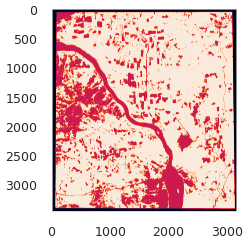

In [127]:
plt.imshow(output_mask)

In [134]:
raster_output = '../rasters/prediction_bratsk_texture.tif'
status = save_tif_rasterio(raster_input=fname, 
                           raster_output=raster_output,
                           values=output_mask,
                          nodata=-1)
print(status)

Saved geotiff: ../rasters/prediction_bratsk_texture.tif
None


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


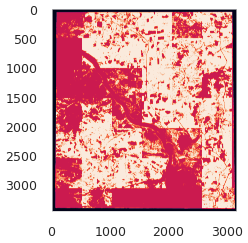

In [117]:
plt.imshow(output_mask)


## Классификация всего растра 

In [ ]:


# Задаем размер кусочков (тайлов), которые будем классифицировать
tile_width, tile_height = 512, 512

# forest_model = load('../models/forest_model_svc.joblib')
forest_type_model = load('../models/forest_type_model_SVC.joblib')
non_forest_model = load('../models/svc_grid_p_nf.joblib')
deciduous_model = keras.models.load_model('../models/cnn_deciduous')
coniferous_model = keras.models.load_model('../models/cnn_coniferous')
scaler = load('../models/forest_scaler.joblib')


dict_coniferous = {0:ForestClasses.Pine.value,
                   1:ForestClasses.Silver_fir.value,
                   -1:-1}
dict_deciduous = {0:ForestClasses.Birch.value,
                   1:ForestClasses.Aspen.value,
                   -1:-1}

with rio.open(fname, 'r+') as src:
    meta = src.meta.copy()
    output_mask = np.zeros(shape = (meta['height'], meta['width']))
    # Здесь можно добавить tqdm для отслеживания процесса
    for window, transform in get_tiles(src, 
                                       width=tile_width,
                                       height=tile_height):
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        
        x = src.read(window=window)
        # get pixels for classification from tiff tile
        df = get_dataset(x)

        # vector to save results
        columns=['forest', 'non_forest','forest_type',
                 'coniferous', 'deciduous']
        forecast=pd.DataFrame(data=np.ones(shape=(len(df), 5))*-1,
                              columns=columns)
        
        mask_nan = df.iloc[:, :5].sum(axis=1)==0
    
        land_df = df.loc[~mask_nan]
        land_df.iloc[:, :] = scaler.transform(land_df.iloc[:, :])
        
        forest_preds = forest_model.predict(land_df.values)
        forecast.loc[~mask_nan, 'forest'] = forest_preds
        # Predict forest type -> 1 - coniferous, 0 - deciduous
        
        mask_forest = forecast['forest'] == 1
        f_type_preds = forest_type_model.predict(land_df.loc[mask_forest])
        forecast.loc[mask_forest, 'forest_type'] = f_type_preds

        non_forest = non_forest_model.predict(land_df.loc[forecast['forest'] == 0])
        forecast.loc[forecast['forest'] == 0,'non_forest'] = non_forest
        
        # Predict deciduous -> Birch - 0, Aspen - 1
        data_for_cnn = land_df.loc[forecast['forest_type']==0].values
        ip_shape = data_for_cnn.shape
        data_for_cnn = data_for_cnn.reshape(-1, ip_shape[1], 1)
        pred_deciduous = (deciduous_model.predict(data_for_cnn)>0.5).astype("int32")
        forecast.loc[forecast['forest_type']==0, 'deciduous'] = pred_deciduous[:,0]
        
        # Predict coniferous -> Pine - 0, Silver fir - 1
        data_for_cnn = land_df.loc[forecast['forest_type']==1].values
        ip_shape = data_for_cnn.shape
        data_for_cnn = data_for_cnn.reshape(-1, ip_shape[1], 1)
        pred_coniferous = (coniferous_model.predict(data_for_cnn)>0.5).astype("int32")
        forecast.loc[forecast['forest_type']==1, 'coniferous'] = pred_coniferous[:,0]
        
        
        forecast['coniferous'] = forecast['coniferous'].apply(lambda x: dict_coniferous[x])
        forecast['deciduous'] = forecast['deciduous'].apply(lambda x: dict_deciduous[x])
        forecast_vector = forecast.max(axis=1)
        forest_tile = forecast_vector.values.reshape(meta['height'], meta['width'])
        ranges = window.toranges()
        output_mask[ranges[0][0]:ranges[0][1],ranges[1][0]:ranges[1][1]] = forest_tile
        print(window)
        # break 
raster_output = '../rasters/prediction_bratsk.tif'
status = save_tif(raster_input=fname, raster_output=raster_output, values=output_mask)
print(status)